In [1]:
# Importing Important Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Data Understanding

In [4]:
## MIT-BIH Data
ecg_train = pd.read_csv(r"C:\Users\Saydain S\OneDrive\Desktop\ECG Heartbeat Classification DataSet\mitbih_train.csv", header=None)
ecg_test = pd.read_csv(r"C:\Users\Saydain S\OneDrive\Desktop\ECG Heartbeat Classification DataSet\mitbih_test.csv", header=None)

In [5]:
# Checking The Class Imbalance of  dataset
ecg_train[187] = ecg_train[187].astype(int)
equals = ecg_train[187].value_counts()
print(equals)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


In [6]:
# Getting the detailed info of both train and test datasets
print("MIT Train dataset info")
print(ecg_train.info())
print("MIT Test dataset info")
print(ecg_test.info())

MIT Train dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(187), int32(1)
memory usage: 125.2 MB
None
MIT Test dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None


In [7]:
# Now Describing the training and the test dataset

print("ECG Training Data\n", ecg_train.describe())
print("ECG Test Data\n", ecg_test.describe())


ECG Training Data
                 0             1             2             3             4    \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.890360      0.758160      0.423972      0.219104      0.201127   
std        0.240909      0.221813      0.227305      0.206878      0.177058   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.921922      0.682486      0.250969      0.048458      0.082329   
50%        0.991342      0.826013      0.429472      0.166000      0.147878   
75%        1.000000      0.910506      0.578767      0.341727      0.258993   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.210399      0.205808      0.201773      0.198691      0.196757   
std        0.171909      0.17848

## Renaming the classes using the scientific nomenclatures


In [8]:
# Assuming the target column is our last column
target_index = ecg_train.shape[1]-1

# Gathering all the unique values in the target column
class_labels = ecg_train[target_index].unique()

# Now Assigning the scientific nomenclatures to the class labels from our domain
# knowledge
nomen_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

# Printing class names with their associated scientific names
for label in nomen_names:
    print(f"Class Label {label}: {nomen_names[label]}")

Class Label 0: Normal Beats
Class Label 1: Supraventricular Ectopy Beats
Class Label 2: Ventricular Ectopy Beats
Class Label 3: Fusion Beats
Class Label 4: Unclassifiable Beats


In [9]:
nom_list = list(nomen_names.values())
nom_list

['Normal Beats',
 'Supraventricular Ectopy Beats',
 'Ventricular Ectopy Beats',
 'Fusion Beats',
 'Unclassifiable Beats']

# Preprocessing

In [10]:
# Splitting Target and other values
ecg_train_target = ecg_train[187]
ecg_test_target = ecg_test[187]
train_val = ecg_train.drop(187,axis=1)
test_val = ecg_test.drop(187,axis=1)

### Low-Pass Filter: In the context of ECG Signals, it helps remove High-Frequency noise while retaining the important Low-Frequency components related to unusual heart activity.

### Butter_Lowpass_Filter Function: This Function takes parameters such as the cutoff Frequency, sampling rate, and filter order, and returns the filtered signal.

In [11]:
from scipy.signal import butter, filtfilt
# Filtering for Train Values
ecg_data = ecg_train
ecg_signal = train_val
ecg_label = ecg_train_target 
sampling_rate = 300
def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    freqi = 0.5*fs
    normal_cutoff = cutoff_freq/freqi
    b,a = butter(order, normal_cutoff, btype='low', analog=False)
    filt_data = filtfilt(b,a,data)
    return filt_data

# Showing Example
cutoff_freq = 125 
filt_ecg_signal = butter_lowpass_filter(ecg_signal, cutoff_freq, sampling_rate)


In [12]:
train_val

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Filtering for Train Values
filt_ecg_signal

array([[ 9.78025359e-01,  9.31228125e-01,  6.72655870e-01, ...,
        -1.09241887e-08,  5.64004720e-09, -4.45968278e-10],
       [ 9.60060339e-01,  8.57851804e-01,  4.71493020e-01, ...,
         2.68216982e-06, -9.78011243e-07, -5.00657850e-07],
       [ 1.00008352e+00,  6.55272004e-01,  1.93779589e-01, ...,
        -5.08565457e-09,  3.38196512e-09, -1.34206895e-09],
       ...,
       [ 9.06053988e-01,  6.26892529e-01,  5.91530715e-01, ...,
        -1.21672499e-06,  3.25671883e-07,  4.04099652e-07],
       [ 8.58253894e-01,  6.70658402e-01,  8.00159391e-01, ...,
        -2.01228176e-07,  7.49996511e-08,  3.51241515e-08],
       [ 9.01512019e-01,  8.46941636e-01,  7.98770636e-01, ...,
        -7.81099988e-07,  4.98316305e-07, -1.74452632e-07]])

In [14]:
test_val

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Filtering for Test Values
filt_ecg_signal_test = butter_lowpass_filter(test_val, cutoff_freq, sampling_rate)


In [16]:
filt_ecg_signal_test

array([[ 1.00004289e+00,  7.51682644e-01,  1.23223863e-01, ...,
        -2.24582001e-07,  7.35644454e-08,  5.44097956e-08],
       [ 9.08476997e-01,  7.85617846e-01,  5.27877448e-01, ...,
        -1.10038438e-08,  5.95287910e-09, -8.56784724e-10],
       [ 7.29999815e-01,  2.07607365e-01,  8.94294859e-03, ...,
        -4.60299111e-08,  7.34562841e-08, -7.64171920e-08],
       ...,
       [ 1.00005344e+00,  9.62717192e-01,  6.28419271e-01, ...,
         1.05951485e-07, -2.38688776e-07,  2.80308994e-07],
       [ 9.84229411e-01,  5.76291528e-01,  5.90984058e-01, ...,
         3.79262186e-07, -3.85683279e-07,  3.00297169e-07],
       [ 9.73965751e-01,  9.13437923e-01,  8.65127682e-01, ...,
         1.86500884e-07, -4.57296505e-07,  5.49131548e-07]])

# EDA

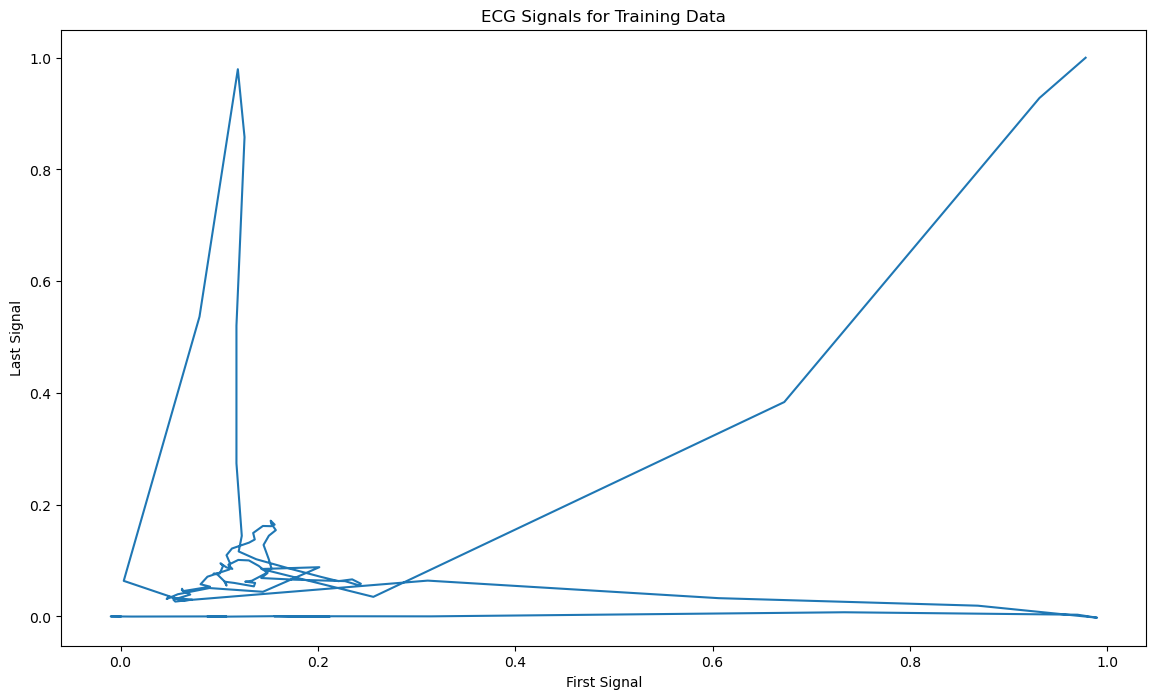

In [17]:
# Understanding the training data using Visualization 
import seaborn as sns

# Time Series Plot
plt.figure(figsize=(14,8))
plt.plot(filt_ecg_signal[0],filt_ecg_signal[187])
plt.title('ECG Signals for Training Data')
plt.xlabel('First Signal')
plt.ylabel('Last Signal')
plt.show()

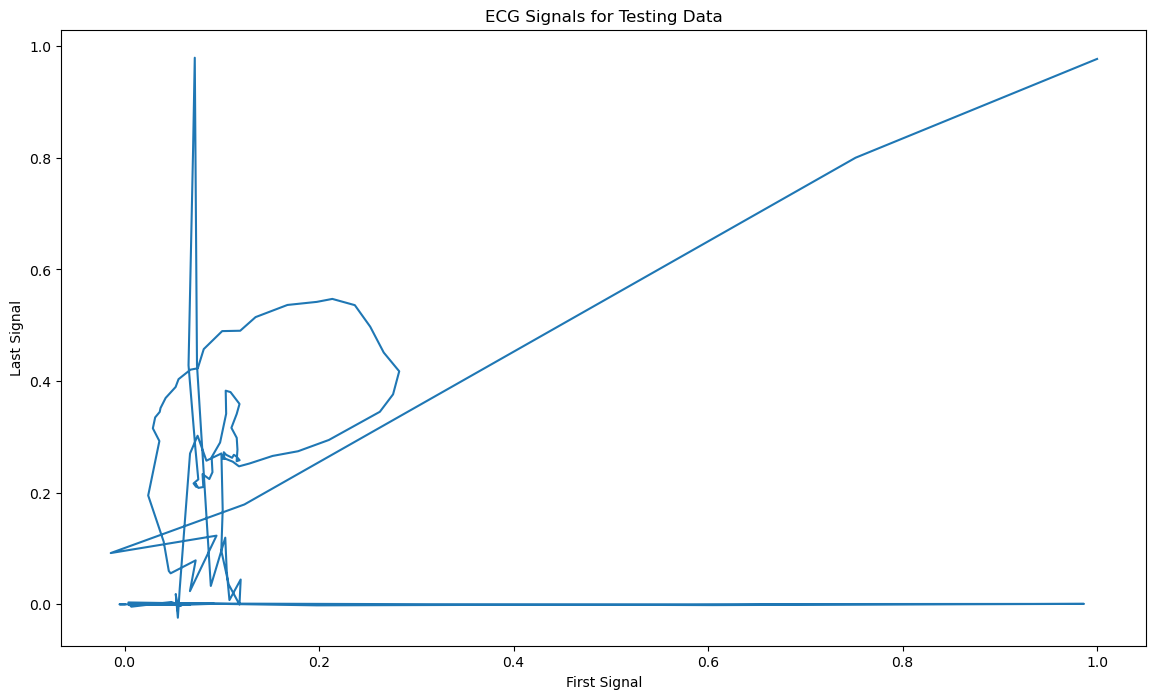

In [18]:
# Understanding the testing data using Visualization 
import seaborn as sns

# Time Series Plot
plt.figure(figsize=(14,8))
plt.plot(filt_ecg_signal_test[0],filt_ecg_signal_test[187])
plt.title('ECG Signals for Testing Data')
plt.xlabel('First Signal')
plt.ylabel('Last Signal')
plt.show()

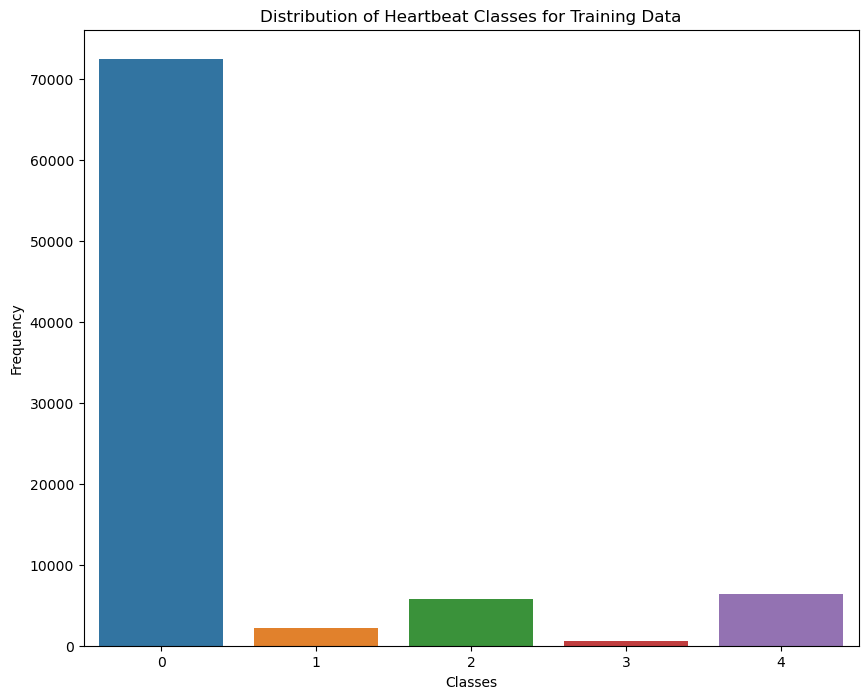

In [19]:
# Histogram for the ECG Signal for the last Column for Training Data
plt.figure(figsize=(10,8))
sns.countplot(x= 187, data=ecg_train)
plt.title('Distribution of Heartbeat Classes for Training Data')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

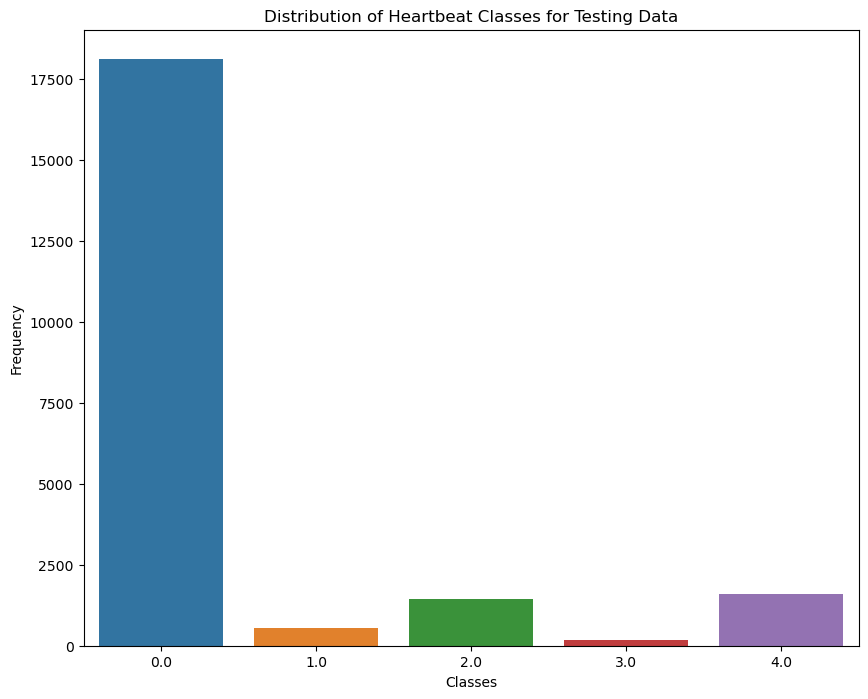

In [20]:
# Histogram for the ECG Signal for the last Column for Testing Data
plt.figure(figsize=(10,8))
sns.countplot(x= 187, data=ecg_test)
plt.title('Distribution of Heartbeat Classes for Testing Data')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [21]:
ecg_train_target

0        0
1        0
2        0
3        0
4        0
        ..
87549    4
87550    4
87551    4
87552    4
87553    4
Name: 187, Length: 87554, dtype: int32

In [22]:
ecg_test_target

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21887    4.0
21888    4.0
21889    4.0
21890    4.0
21891    4.0
Name: 187, Length: 21892, dtype: float64

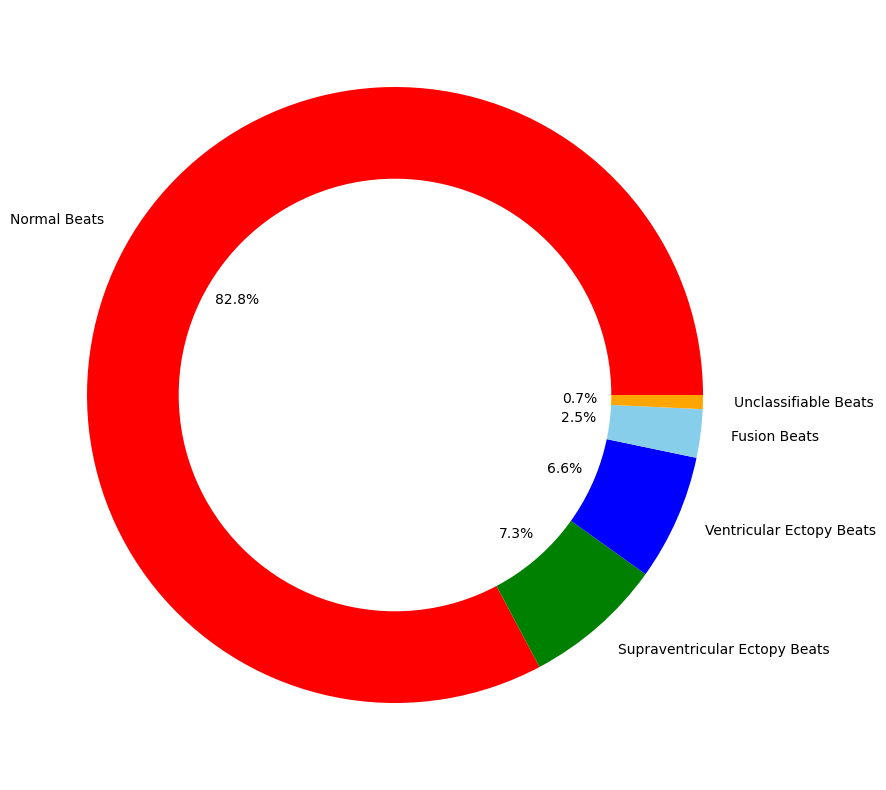

In [23]:
# Pie Chart for the training dataset

plt.figure(figsize=(20,10))
circ = plt.Circle( (0,0), 0.7, color='white')
plt.pie(ecg_train_target.value_counts(), labels=nom_list, colors=['red','green','blue','skyblue','orange'],
        autopct='%1.1f%%')
pl = plt.gcf()
pl.gca().add_artist(circ)
plt.show()

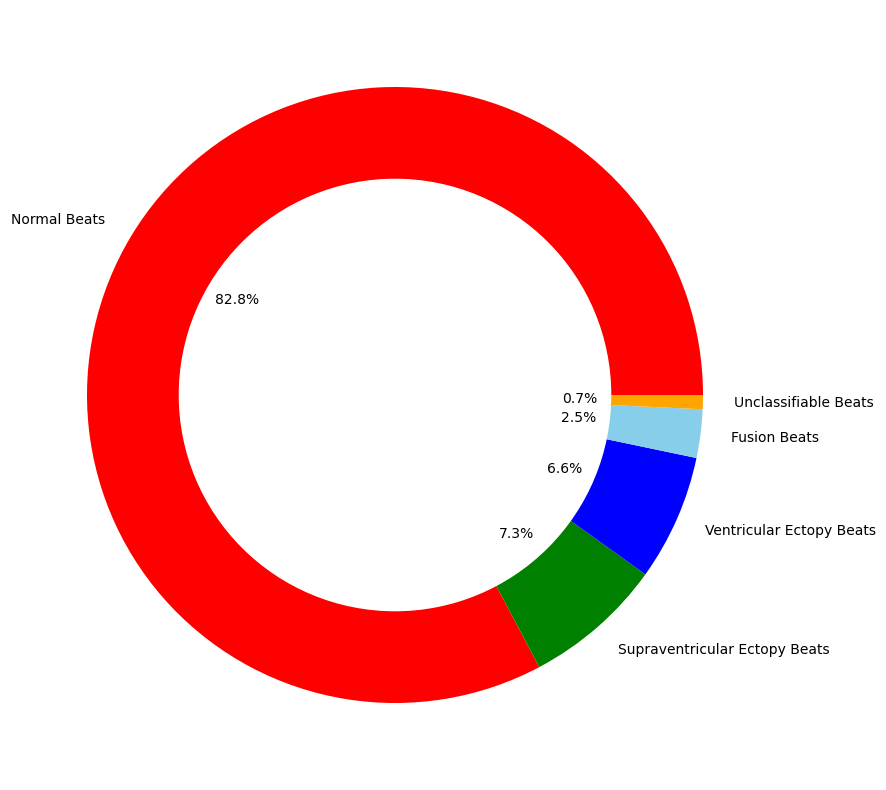

In [24]:
# Pie Chart for the testing dataset

plt.figure(figsize=(20,10))
circ = plt.Circle( (0,0), 0.7, color='white')
plt.pie(ecg_test_target.value_counts(), labels=nom_list, colors=['red','green','blue','skyblue','orange'],
        autopct='%1.1f%%')
pl = plt.gcf()
pl.gca().add_artist(circ)
plt.show()

In [25]:
ecg_train.isnull().sum().value_counts()

0    188
Name: count, dtype: int64

# Further Data Preprocessing (i.e. Resampling and Normalization)

In [26]:
from imblearn.under_sampling import TomekLinks

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [29]:
filt_ecg_signal.shape

(87554, 187)

In [30]:
ecg_train_target.shape

(87554,)

In [31]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(filt_ecg_signal, ecg_train_target)

In [32]:
X_res_test, y_res_test = smote.fit_resample(filt_ecg_signal_test, ecg_test_target)

In [33]:
# Visualization after Resampling using SMOTE

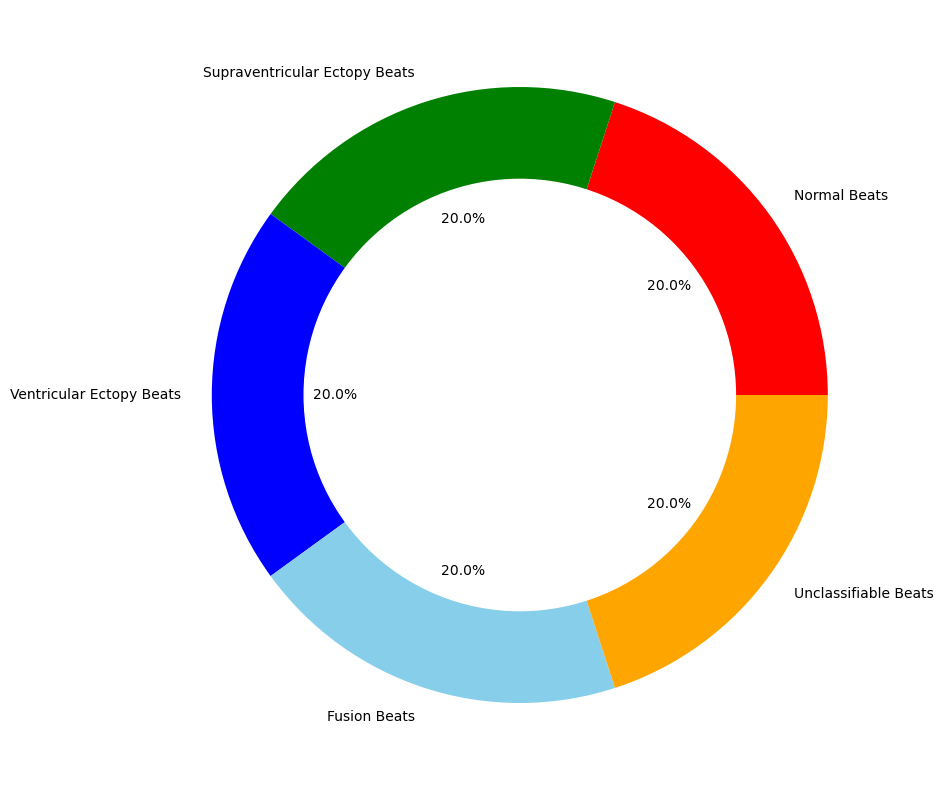

In [34]:
# For Training set after resampling
plt.figure(figsize=(20,10))
circ = plt.Circle( (0,0), 0.7, color='white')
plt.pie(y_res.value_counts(), labels=nom_list, colors=['red','green','blue','skyblue','orange'],
        autopct='%1.1f%%')
pl = plt.gcf()
pl.gca().add_artist(circ)
plt.show()

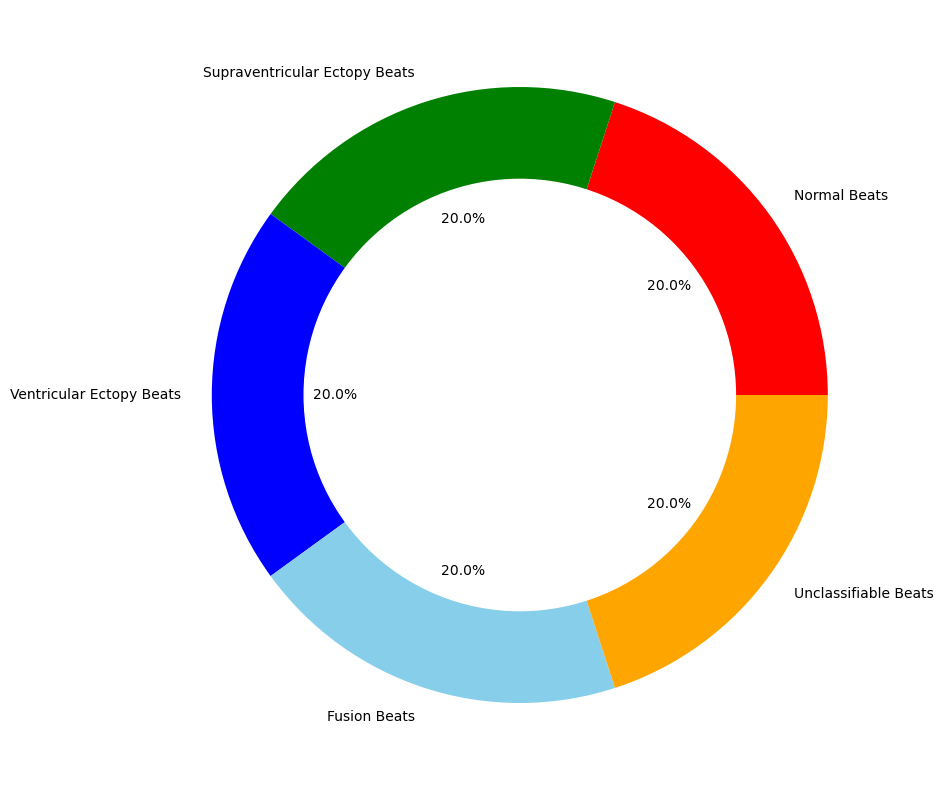

In [36]:
# For Testing set after resampling
plt.figure(figsize=(20,10))
circ = plt.Circle( (0,0), 0.7, color='white')
plt.pie(y_res_test.value_counts(), labels=nom_list, colors=['red','green','blue','skyblue','orange'],
        autopct='%1.1f%%')
pl = plt.gcf()
pl.gca().add_artist(circ)
plt.show()

In [37]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data only, then transform both training and test data
ecg_train_scaled = scaler.fit_transform(X_res)
ecg_test_scaled = scaler.transform(X_res_test)

# Model Training and Evaluation

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Use Random Forest Regressor
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

# Train the classifier using extracted features and corresponding labels
rf_classifier.fit(ecg_train_scaled, y_res)


# Predict labels for test data
y_pred_test = rf_classifier.predict(ecg_test_scaled)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_res_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.9112595209184237


In [ ]:
# Hyperparamter tuning of Random Forest Classifier

In [39]:
# Generate classification report for Random Forest
report = classification_report(y_res_test, y_pred_test)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.99      0.85     18118
         1.0       0.99      0.82      0.90     18118
         2.0       0.93      0.95      0.94     18118
         3.0       0.98      0.82      0.89     18118
         4.0       1.00      0.98      0.99     18118

    accuracy                           0.91     90590
   macro avg       0.93      0.91      0.91     90590
weighted avg       0.93      0.91      0.91     90590



In [41]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 919.0 kB/s eta 0:01:49
   ---------------------------------------- 0.5/99.8 MB 3.6 MB/s eta 0:00:28
    --------------------------------------- 1.4/99.8 MB 8.2 MB/s eta 0:00:13
    --------------------------------------- 2.3/99.8 MB 10.4 MB/s eta 0:00:10
   - -------------------------------------- 3.4/99.8 MB 12.8 MB/s eta 0:00:08
   - -------------------------------------- 4.8/99.8 MB 15.4 MB/s eta 0:00:07
   -- ------------------------------------- 6.6/99.8 MB 18.3 MB/s eta 0:00:06
   --- ------------------------------------ 7.6/99.8 MB 19.5 MB/s eta 0:00:05
   --- ------------------------------------ 9.7/99.8 MB 21.5 MB/s eta 0:00:05
   ---- ----------------------------------- 11.1/99.8 MB 29.7 MB/s eta 0:00:03
   ---- ----------------------------------- 12.2/99.8 MB 29.7 MB/s eta 0:00:03
 

## XGBoost Classifier

In [42]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [43]:
model1 = xgb.XGBClassifier(
    objective = 'multi:softmax',
    max_depth=5,
    learning_rate=0.01,
    n_estimators=100
)

In [44]:
model1.fit(X_res,y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [45]:
predict = model1.predict(filt_ecg_signal_test)

In [46]:
xgb_accur = accuracy_score(ecg_test_target, predict)
print(f"XGBoost Accuracy: {xgb_accur:.5f}")

XGBoost Accuracy: 0.83962


In [47]:
xgb_report=classification_report(ecg_test_target,predict)
print(xgb_report)

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     18118
         1.0       0.29      0.77      0.42       556
         2.0       0.68      0.85      0.76      1448
         3.0       0.11      0.88      0.19       162
         4.0       0.77      0.94      0.85      1608

    accuracy                           0.84     21892
   macro avg       0.57      0.86      0.62     21892
weighted avg       0.92      0.84      0.87     21892



In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
model2 = xgb.XGBClassifier()

In [50]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

  'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.8, 1.0]

In [51]:
# After Hyperparameter Tuning

model3 = xgb.XGBClassifier(
    objective = 'multi:softmax',
    max_depth=7,
    learning_rate=0.2,
    n_estimators=100
)

In [52]:
model3.fit(X_res,y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [53]:
predict2 = model3.predict(filt_ecg_signal_test)

In [54]:
xgb_accur = accuracy_score(ecg_test_target, predict2)
print(f"XGBoost Accuracy: {xgb_accur:.5f}")

XGBoost Accuracy: 0.96656


In [55]:
xgb_report2=classification_report(ecg_test_target,predict2)
print(xgb_report2)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.63      0.80      0.71       556
         2.0       0.91      0.94      0.92      1448
         3.0       0.55      0.83      0.66       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.81      0.90      0.85     21892
weighted avg       0.97      0.97      0.97     21892



## Building our own Neural Network

In [56]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

In [57]:
from sklearn.metrics import classification_report

In [58]:
from sklearn.metrics import auc, accuracy_score, classification_report, \
     confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [59]:
# Splitting Target and other values
ecg_train_target = ecg_train[187]
ecg_test_target = ecg_test[187]
train_val = ecg_train.drop(187,axis=1)
test_val = ecg_test.drop(187,axis=1)

In [60]:
# Domain Knowledge Filtering for Train_val
filt_ecg_signal

array([[ 9.78025359e-01,  9.31228125e-01,  6.72655870e-01, ...,
        -1.09241887e-08,  5.64004720e-09, -4.45968278e-10],
       [ 9.60060339e-01,  8.57851804e-01,  4.71493020e-01, ...,
         2.68216982e-06, -9.78011243e-07, -5.00657850e-07],
       [ 1.00008352e+00,  6.55272004e-01,  1.93779589e-01, ...,
        -5.08565457e-09,  3.38196512e-09, -1.34206895e-09],
       ...,
       [ 9.06053988e-01,  6.26892529e-01,  5.91530715e-01, ...,
        -1.21672499e-06,  3.25671883e-07,  4.04099652e-07],
       [ 8.58253894e-01,  6.70658402e-01,  8.00159391e-01, ...,
        -2.01228176e-07,  7.49996511e-08,  3.51241515e-08],
       [ 9.01512019e-01,  8.46941636e-01,  7.98770636e-01, ...,
        -7.81099988e-07,  4.98316305e-07, -1.74452632e-07]])

In [61]:
# Domain Knowledge Filtering for Test_val
filt_ecg_signal_test

array([[ 1.00004289e+00,  7.51682644e-01,  1.23223863e-01, ...,
        -2.24582001e-07,  7.35644454e-08,  5.44097956e-08],
       [ 9.08476997e-01,  7.85617846e-01,  5.27877448e-01, ...,
        -1.10038438e-08,  5.95287910e-09, -8.56784724e-10],
       [ 7.29999815e-01,  2.07607365e-01,  8.94294859e-03, ...,
        -4.60299111e-08,  7.34562841e-08, -7.64171920e-08],
       ...,
       [ 1.00005344e+00,  9.62717192e-01,  6.28419271e-01, ...,
         1.05951485e-07, -2.38688776e-07,  2.80308994e-07],
       [ 9.84229411e-01,  5.76291528e-01,  5.90984058e-01, ...,
         3.79262186e-07, -3.85683279e-07,  3.00297169e-07],
       [ 9.73965751e-01,  9.13437923e-01,  8.65127682e-01, ...,
         1.86500884e-07, -4.57296505e-07,  5.49131548e-07]])

### For Training Data after Butter Filteration

In [62]:
# Split the filt_ecg_signal data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filt_ecg_signal, ecg_train_target, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [63]:
X_train

array([[ 0.44071979,  1.10299806,  1.39836579, ..., -0.09332813,
        -0.09083619, -0.0891792 ],
       [ 0.45646993, -0.62618856, -0.79753002, ..., -0.093375  ,
        -0.0907821 , -0.0892254 ],
       [ 0.4060142 ,  0.81901255,  0.55654344, ..., -0.09341885,
        -0.09070117, -0.08931573],
       ...,
       [ 0.45653788,  0.94491166,  0.52717779, ..., -0.09342377,
        -0.09073365, -0.0892613 ],
       [ 0.07324215,  1.1082925 ,  0.13970261, ..., -0.09337374,
        -0.09078367, -0.08922397],
       [-0.46300688, -0.28002413, -0.04062521, ..., -0.09336951,
        -0.09078516, -0.08922507]])

In [64]:
X_test

array([[ 0.31509754,  0.13522705, -1.35463638, ..., -0.09337272,
        -0.09078399, -0.0892243 ],
       [ 0.45635056, -0.78390221, -1.79883335, ..., -0.09336809,
        -0.09078778, -0.08922216],
       [-0.2419337 , -0.18295194,  0.27678244, ..., -0.09337265,
        -0.090784  , -0.08922434],
       ...,
       [-3.63897583, -3.33495742, -1.79561809, ..., -0.09346447,
        -0.09070411, -0.08927434],
       [-3.68719801, -1.99716384, -0.59609752, ..., -0.09339077,
        -0.09078694, -0.08920515],
       [-3.68671926, -2.61781328, -0.598143  , ...,  0.34473217,
        -0.39168228, -0.01540548]])

In [65]:
X_train.shape

(70043, 187)

In [66]:
X_test.shape

(17511, 187)

### Our First NN Model

In [67]:
# Create the neural network model
model1 = Sequential()
model1.add(Dense(256, activation = 'relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')


Epoch 1/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8250 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8268 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8265 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8277 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8270 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8260 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8271 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 8/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8277 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 9

In [68]:
# Evaluate the model
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     14579
           1       0.00      0.00      0.00       426
           2       0.00      0.00      0.00      1112
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00      1249

    accuracy                           0.83     17511
   macro avg       0.17      0.20      0.18     17511
weighted avg       0.69      0.83      0.76     17511



### Our Second NN Model

In [69]:
# Creating another Neural Network with different Activation Function
# Create the neural network model
model2 = Sequential()
model2.add(Dense(64, activation = 'leaky_relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8021 - loss: 0.0000e+00 - val_accuracy: 0.8241 - val_loss: 0.0000e+00
Epoch 2/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.8195 - loss: 0.0000e+00 - val_accuracy: 0.8279 - val_loss: 0.0000e+00
Epoch 3/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 913us/step - accuracy: 0.8195 - loss: 0.0000e+00 - val_accuracy: 0.8271 - val_loss: 0.0000e+00
Epoch 4/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.8237 - loss: 0.0000e+00 - val_accuracy: 0.8224 - val_loss: 0.0000e+00
Epoch 5/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step - accuracy: 0.8198 - loss: 0.0000e+00 - val_accuracy: 0.8257 - val_loss: 0.0000e+00
Epoch 6/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step - accuracy: 0.8205 - loss: 0.0000e+00 - val_accuracy: 0.8272 - val_loss: 0.0000e+00
Epoch 7/15
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.8216 - loss: 0.0000e+00 - val_accuracy: 0.8282 - val_loss: 0.0000e+00
Epoch 8/15
2189/2189 ━

In [70]:
# Evaluate the model
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     14579
           1       0.01      0.08      0.02       426
           2       0.00      0.00      0.00      1112
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00      1249

    accuracy                           0.83     17511
   macro avg       0.19      0.21      0.20     17511
weighted avg       0.80      0.83      0.81     17511



### Our Third NN Model

In [71]:
# Create the neural network model
model3 = Sequential()
model3.add(Dense(256, activation = 'leaky_relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='tanh'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='tanh'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='leaky_relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='leaky_relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='leaky_relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model3.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7915 - loss: 0.0000e+00 - val_accuracy: 0.8326 - val_loss: 0.0000e+00
Epoch 2/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8243 - loss: 0.0000e+00 - val_accuracy: 0.8326 - val_loss: 0.0000e+00
Epoch 3/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8258 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 4/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8233 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 5/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8274 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 6/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8269 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 7/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8277 - loss: nan - val_accuracy: 0.8326 - val_loss: nan
Epoch 8/50
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8257 - loss: nan - val_accuracy: 0.8

In [72]:
# Evaluate the model
y_pred3 = (model3.predict(X_test) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred3)

# Print the classification report
print(report)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     14579
           1       0.00      0.00      0.00       426
           2       0.00      0.00      0.00      1112
           3       0.00      0.00      0.00       145
           4       0.00      0.00      0.00      1249

    accuracy                           0.83     17511
   macro avg       0.17      0.20      0.18     17511
weighted avg       0.69      0.83      0.76     17511



### For Testing Data after Butter Filteration

In [73]:
# Split the filt_ecg_signal_test data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(filt_ecg_signal_test, ecg_test_target, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [74]:
# Creating another Neural Network with different Activation Function
# Create the neural network model
model2 = Sequential()
model2.add(Dense(64, activation = 'leaky_relu', input_shape=(X_train2.shape[1],)))
model2.add(Dense(32, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model2.fit(X_train2, y_train2, epochs=15, batch_size=32, validation_data=(X_test2, y_test2))

# Evaluate the model
loss, accuracy = model2.evaluate(X_test2, y_test2)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7844 - loss: 0.0000e+00 - val_accuracy: 0.8153 - val_loss: 0.0000e+00
Epoch 2/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.8168 - loss: 0.0000e+00 - val_accuracy: 0.8221 - val_loss: 0.0000e+00
Epoch 3/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.8112 - loss: 0.0000e+00 - val_accuracy: 0.8166 - val_loss: 0.0000e+00
Epoch 4/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.8223 - loss: 0.0000e+00 - val_accuracy: 0.8159 - val_loss: 0.0000e+00
Epoch 5/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8166 - loss: 0.0000e+00 - val_accuracy: 0.8239 - val_loss: 0.0000e+00
Epoch 6/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.8162 - loss: 0.0000e+00 - val_accuracy: 0.8187 - val_loss: 0.0000e+00
Epoch 7/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8210 - loss: 0.0000e+00 - val_accuracy: 0.8226 - val_loss: 0.0000e+00
Epoch 8/15
548/548 ━━━━━━━━━━━━━━━━━━━

In [75]:
# Evaluate the model
y_pred = (model2.predict(X_test2) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test2, y_pred)

# Print the classification report
print(report)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3625
         1.0       0.02      0.09      0.03       106
         2.0       0.00      0.00      0.00       289
         3.0       0.00      0.00      0.00        35
         4.0       0.00      0.00      0.00       324

    accuracy                           0.82      4379
   macro avg       0.19      0.22      0.20      4379
weighted avg       0.79      0.82      0.80      4379



In [76]:
# Create Our own neural network model
model1 = Sequential()
model1.add(Dense(256, activation = 'relu', input_shape=(X_train2.shape[1],)))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model1.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_data=(X_test2, y_test2))

# Evaluate the model
loss, accuracy = model1.evaluate(X_test2, y_test2)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8152 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8314 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8280 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8237 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8313 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8301 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8284 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8196 - loss: nan - val_accuracy: 0.8278 - val_loss: nan
Epoch 9/50
548/548 ━━━━━

In [77]:
# Evaluate the model
y_pred = (model1.predict(X_test2) > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test2, y_pred)

# Print the classification report
print(report)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      3625
         1.0       0.00      0.00      0.00       106
         2.0       0.00      0.00      0.00       289
         3.0       0.00      0.00      0.00        35
         4.0       0.00      0.00      0.00       324

    accuracy                           0.83      4379
   macro avg       0.17      0.20      0.18      4379
weighted avg       0.69      0.83      0.75      4379

